# Analysis of the in-game economy of a mobile game

# Project goal:

Using player resource mining logs, I will estimate the relative cost of resources compared to each other.\
In the end I plan to summarize all findings in a table with the cost of resources relative to one selected as a benchmark.

# Data description

- level - player level

- user_tier - тир игрplayer tier. This parameter is calculated using level — for each 20 levels players get 1 tier. \
Thus, players at level 1-20 are considered to be tier 1 users, 21-40 — tier 2 etc. The max tier is 5.

- gain_count - the amount of resource received by the user.

- resource_tier - tier of the resource. Most resources received by the player are of the same tier as the player's tier

- resource - resource name. Resources of the same type but different tires will have unique names.\
    For example, wls2_resource_primary_wood_1 and wls2_resource_primary_wood_2 are two tree type resources of different tires. Thus they will have different names.

- playtime - how much time the player spent in the game in seconds since the beginning of the first session.

# Import data and libraries

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = "{:,.2f}".format

import numpy as np
from scipy import stats as st
import statistics
import collections

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
plt.rcParams["figure.figsize"] = (12,8)
sns.set_theme(style="darkgrid")

In [2]:
data = pd.read_csv('C:/datasets/game_resources.csv')

In [3]:
data.head()

,Unnamed: 0,user_id,user_tier,level,resource_tier,gain_count,resource,playtime
0,73728,0000197394df45db9fe1d5db475a2809,4,67,5,6,wls2_resourse_primary_fiber_5,287991
1,73729,0000197394df45db9fe1d5db475a2809,4,67,5,9,wls2_resourse_primary_fiber_5,287992
2,73730,0000197394df45db9fe1d5db475a2809,4,67,5,9,wls2_resourse_primary_fiber_5,287993
3,73731,0000197394df45db9fe1d5db475a2809,4,67,5,6,wls2_resourse_primary_fiber_5,287994
4,73732,0000197394df45db9fe1d5db475a2809,4,72,5,1,wls2_resourse_primary_fiber_5,383764


# EDA

## Plan

1. Get a first look at the data, check the distributions
2. Study the players, try to group players into categories and analyze them.
3. Explore the relationship of resources to each other both within each category (compare tree level 1 to tree level 3) and between categories (compare tree and stone)

In [4]:
data.shape

(15422689, 8)

In [5]:
data.duplicated().sum() # a casual duplicates check

0

In [6]:
data.isnull().sum() # missing values?

Unnamed: 0       0
user_id          0
user_tier        0
level            0
resource_tier    0
gain_count       0
resource         0
playtime         0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15422689 entries, 0 to 15422688
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   Unnamed: 0     int64 
 1   user_id        object
 2   user_tier      int64 
 3   level          int64 
 4   resource_tier  int64 
 5   gain_count     int64 
 6   resource       object
 7   playtime       int64 
dtypes: int64(6), object(2)
memory usage: 941.3+ MB


In [8]:
data.describe()

,Unnamed: 0,user_tier,level,resource_tier,gain_count,playtime
count,"15,422,689.00","15,422,689.00","15,422,689.00","15,422,689.00","15,422,689.00","15,422,689.00"
mean,"492,088.33",2.69,43.31,2.39,3.55,"261,894.21"
std,"289,272.36",1.34,25.67,1.49,5.84,"393,974.42"
min,0.00,1.00,1.00,1.00,1.00,10.00
25%,"240,979.00",2.00,21.00,1.00,1.00,"15,666.00"
50%,"485,910.00",2.00,38.00,2.00,2.00,"71,657.00"
75%,"742,955.00",4.00,67.00,4.00,3.00,"386,899.00"
max,"999,999.00",5.00,106.00,5.00,300.00,"9,172,950.00"


- According to the description, users are divided into 5 tiers, the tier rises every 20 levels, after reaching level 80, the tier remains equal 5.
- The data represents users from levels 1 to 106
- It is curious to see such a high maximum value in gain_count - the amount of resources dropped by the player.\
Considering that, on average, players receive about 3 units of a resource at a time, some of the resources may stand out from this picture.\
I should study how often each type of resource is received.
- Also no duplicates, missing values or obvious anomalies in the data! I can continue with the analysis.

In [9]:
data['user_id'].value_counts()

b5e333ced11040348e2baef4b12bf5e7    3686
bc2eb019a3b6419c8837d3fac7a9d32f    3653
fc5349f6d20f4d97aa64ad5fed93e4d7    3531
e46134962e5d472ea9aacac68e8932ab    3451
d177397fd46e478283036de3ab15221e    3442
                                    ... 
ca3f47d88d804fd7818524c17bf61f26       2
cc6e1f8a7d5d4d49aec43de5f1585fa8       1
ac65ea6633ba4d13aca0d2db75f6b4ee       1
ebbb8b0f463e48aea61c4e8eca4f3091       1
b4e08f164f9a45dd9716c76d317ce987       1
Name: user_id, Length: 41543, dtype: int64

There are different numbers of records about different players.\
Some of the players have logs for only one session. Most likely these are the new players who had only one active session when the data was collected.\
In total I have data on 41543 players.

## Explore the behaviour of the players

### Check the user tiers

**The Plan**: Take a closer look at the data and see how many records there are in the dataset on each player.

In [10]:
# calculate number of unique user_tier of each user
unique_user_tier_count = data.groupby('user_id')['user_tier'].unique().str.len()

print('On average each player has information about their performance within {:.2f} user tiers'.
      format(unique_user_tier_count.mean()))

On average each player has information about their performance within 1.80 user tiers


It turns out that, on average, each player's actions are known only when she or he has only 1-2 user tier.\
It is important to check how much information there is about the oldest players.\
If I have full logs on their performance from tier 1 to tier 5, I should be able to get use them as a benchmark to get a better understanding of the in-game economy.

In [11]:
print('On average each player has information about their performance within {:.2f} user tiers'.
      format(data.loc[data['user_tier']>=4].groupby('user_id')['user_tier'].unique().str.len().mean()))

On average each player has information about their performance within 1.29 user tiers


Unfortunately, there is limited information about these players. Most likely the data is only a snapshot of data for a certain calendar period.\
That is, about high-tier players, there is only information about what they did on certain days, and not their full history.

### Explore the user playtime

**The plan**: Explore the playtime parameter. Study distribution of users based on their time in the game.

In [12]:
players_total_time = data.groupby('user_id')['playtime'].max()
players_total_time.sort_values()

user_id
ebbb8b0f463e48aea61c4e8eca4f3091        192
ac65ea6633ba4d13aca0d2db75f6b4ee        205
fcc85a9397a8416a8e8a0419b2a849b5        295
b85cfa76c00f420fa0f4675a37e78a92        410
a0b34ba1ee9d487986ebe8f4c1b9e2fe        418
                                     ...   
daf73eec965b4dbd9f50605e006e83a3    5575478
ee29a0be54d2482999e28cfcde4de901    5621200
ae673dbca0684d5a9a26e378e9b93460    6577230
02bd777aac884d44a8534eb18f91d9e8    6689620
ad1699b8daf347778f91a7282cf98510    9172950
Name: playtime, Length: 41543, dtype: int64

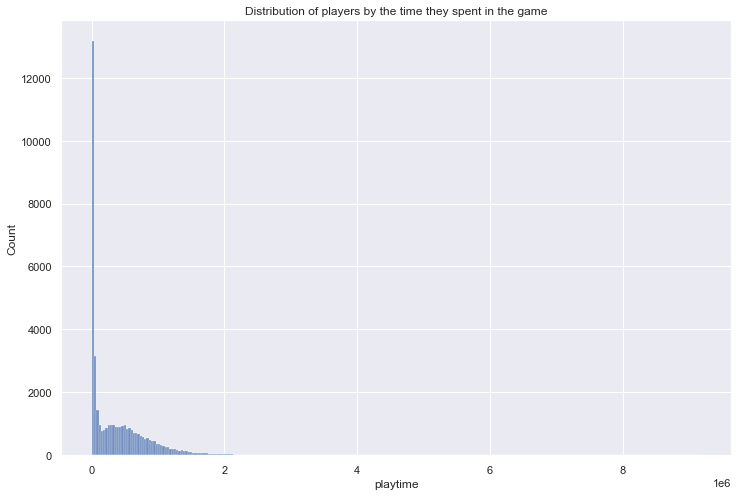

In [13]:
sns.histplot(data=players_total_time)
plt.title('Distribution of players by the time they spent in the game')
plt.show()

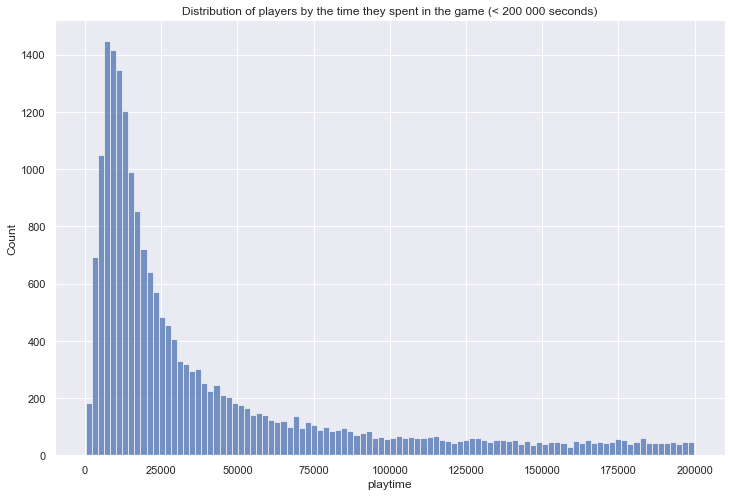

In [14]:
sns.histplot(data=players_total_time[players_total_time<200000], bins=100)
plt.title('Distribution of players by the time they spent in the game (< 200 000 seconds)')
plt.show()

Looks like the Poisson distribution with a peak near 10 000 seconds mark or 2.7 hours.

In [15]:
players_total_time.describe()

count      41,543.00
mean      393,236.22
std       488,432.10
min           192.00
25%        21,667.50
50%       226,242.00
75%       618,069.50
max     9,172,950.00
Name: playtime, dtype: float64

There are different types of players in the game, which will most likely be divided into different categories based on the time they spent in the game.\
For example, the median player spent about 62 hours in the game, while the maximum time spent in the game is about 2548 hours.

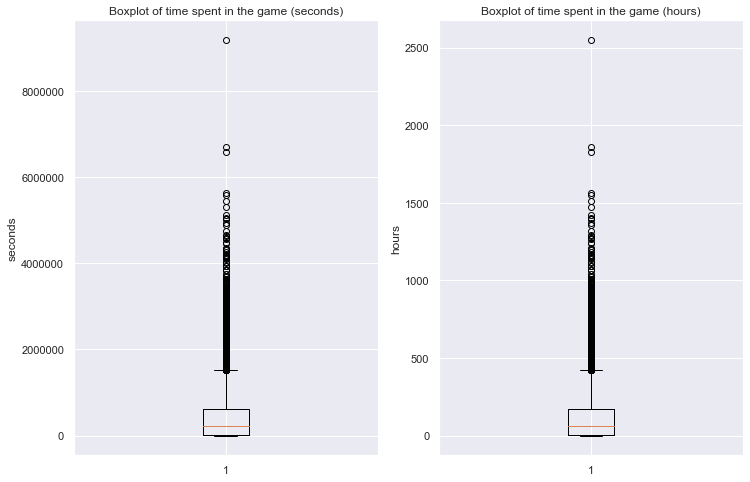

In [16]:
fig, axs = plt.subplots(1, 2)
axs[0].boxplot(players_total_time)
axs[0].set_title('Boxplot of time spent in the game (seconds)')
axs[0].set_ylabel('seconds')
axs[0].ticklabel_format(style='plain', axis='y')

axs[1].boxplot(players_total_time/3600)
axs[1].set_title('Boxplot of time spent in the game (hours)')
axs[1].set_ylabel('hours')

fig.set_size_inches(12, 8, forward=True)
plt.show()

As in the histogram above, it can be seen that most of the players spent significantly less time in the game (about 10000 seconds),\
compared to the players who spent more time on the game (about 500 hours and more)

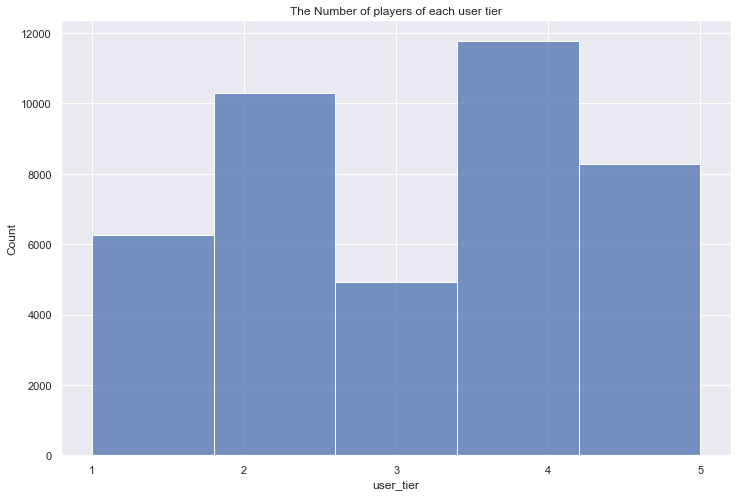

In [17]:
player_tiers = data.groupby('user_id')['user_tier'].max()

sns.histplot(data=player_tiers, bins=5)
plt.xticks([1, 2, 3, 4, 5])
plt.title('The Number of players of each user tier')
plt.show()

In the dataset as a whole, both novice players and "oldies" of tiers 4 and 5 are equally well represented.\
I can also note that the dataset has a good number of experienced tier 4 and 5 players.\
Knowing this, I can calculate the value of rarer resources without worrying that the calculations may be incorrect due to the small number of players mining these resources.

Also it is worth noting that there is a gap at tier 3 users.\
Is it because in general the players don't need much time to move from the third tier to the fourth?\
I will explore this assumption.

In [18]:
def time_to_reach_tier(tier, df):
    """
    Returns the time required for each player to reach selected tier 
    Calculates it as a min registered playtime timestemp of each player of this tier 
    """
    
    sel_tier_df = df[df['user_tier'] >= tier-1] 
    #get a timestamp when this user made first action in new tier
    tier_reach_time = sel_tier_df.loc[sel_tier_df['user_tier']==tier].groupby('user_id')['playtime'].min()
    
    mean_time = round(tier_reach_time.mean())
    median_time = round(tier_reach_time.median())
    
    return tier_reach_time, mean_time, median_time

In [19]:
time_reach_tier_df = pd.DataFrame(columns = ['tier', 'mean_reach_time', 'median_reach_time'])

for i in range(2, 6):
    time, mean_time, median_time = time_to_reach_tier(i, data)
    time_reach_tier_df = time_reach_tier_df.append({'tier':i, 
                                                    'mean_reach_time':mean_time, 
                                                    'median_reach_time':median_time}, 
                                                   ignore_index=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2852\391526712.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time_reach_tier_df = time_reach_tier_df.append({'tier':i,
C:\Users\Admin\AppData\Local\Temp\ipykernel_2852\391526712.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time_reach_tier_df = time_reach_tier_df.append({'tier':i,
C:\Users\Admin\AppData\Local\Temp\ipykernel_2852\391526712.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time_reach_tier_df = time_reach_tier_df.append({'tier':i,
C:\Users\Admin\AppData\Local\Temp\ipykernel_2852\391526712.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time_reach_tier_df = time_

In [20]:
time_reach_tier_df

,tier,mean_reach_time,median_reach_time
0,2,15647,13082
1,3,136572,101526
2,4,451320,376330
3,5,819758,725774


From the analysis earlier, it became clear that the data contains outliers as some players took much longer than others to complete the game.\
They significantly "stretch" the average, overestimating it. In this case, it would be more indicative to use the median time instead of the average.

For clarity, I will translate the measurement into hours and plot a chart.

In [21]:
time_reach_tier_df.drop('mean_reach_time', axis=1, inplace=True)
time_reach_tier_df['median_reach_time']  = time_reach_tier_df['median_reach_time'] // 3600

In [22]:
time_reach_tier_df # median time in hours

,tier,median_reach_time
0,2,3
1,3,28
2,4,104
3,5,201


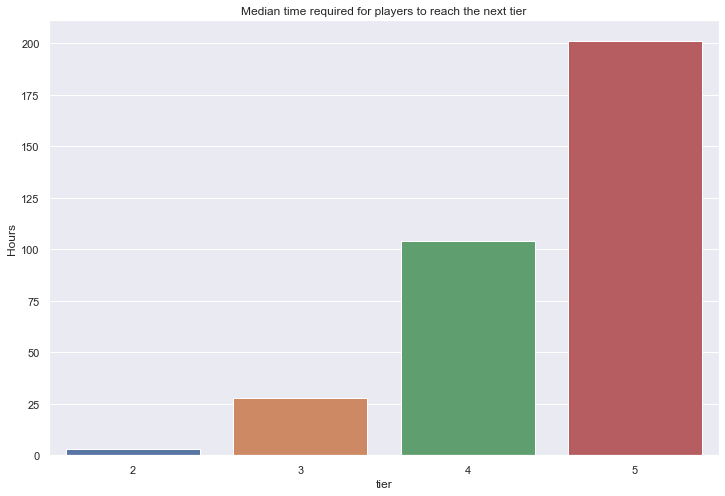

In [23]:
sns.barplot(x='tier', y='median_reach_time', data=time_reach_tier_df)
plt.title('Median time required for players to reach the next tier')
plt.ylabel("Hours")
plt.show()

The graph above shows after how much time in the game players (median time is used) first raise their user_tier to the specified tier\
From this graph, it becomes clear that players really need more and more time to move to each subsequent tier:

- ~3 hours to move to tier 2
- 28 hours to move to tier 3
- 104 hours for tier 4
- 201 hours for Tier 5

Looking at the chart above, you can see that higher tier players spent significantly more time than lower tier players.\
I can conclude that the speed of player progression slows down over time. That is, the first 20 levels are gained faster than the next 20, and so on.\
We can expect to see a similar picture when studying resources:\
resources of higher tiers require more time to collect than resources of lower tiers, which is most likely the reason for the lower leveling speed.

In answer to the earlier question about tier 3 players: it does not appear that tier 3 is the fastest to skip tier.\
Thus, sample disbalance is likely due to randomness. 

## Exploring resources

### What types of resources are there in the game?

In [24]:
data['resource'].unique()

array(['wls2_resourse_primary_fiber_5', 'wls2_resourse_primary_hide_5',
       'wls2_resourse_primary_ore_5', 'wls2_resourse_primary_stone_5',
       'wls2_resourse_primary_wood_5', 'wls2_resourse_primary_fiber_4',
       'wls2_resourse_primary_hide_4', 'wls2_resourse_primary_ore_4',
       'wls2_resourse_primary_stone_4', 'wls2_resourse_primary_wood_4',
       'wls2_resourse_primary_fiber_1', 'wls2_resourse_primary_wood_1',
       'wls2_resourse_primary_hide_1', 'wls2_resourse_primary_stone_1',
       'wls2_resourse_primary_coal_1', 'wls2_resourse_primary_fiber_2',
       'wls2_resourse_primary_fiber_3', 'wls2_resourse_primary_hide_2',
       'wls2_resourse_primary_ore_1', 'wls2_resourse_primary_ore_2',
       'wls2_resourse_primary_stone_2', 'wls2_resourse_primary_wood_2',
       'wls_sulfur', 'wls2_resourse_primary_coal_2',
       'wls2_resourse_primary_wood_3', 'wls2_resourse_primary_hide_3',
       'wls2_resourse_primary_ore_3', 'wls2_resourse_primary_stone_3',
       'wls2_resour

To improve readability, I will shorten the names of resources.

In [25]:
names = list(data['resource'].unique())
print(len(names))

29


In [26]:
new_names = []
for i in names:
    if 'wls2_resourse_primary_' in i:
        new_names.append(i.replace('wls2_resourse_primary_', ''))
    else:
        new_names.append(i)
print(len(new_names)) # make sure that no names were missed

29


In [27]:
data['resource'] = data['resource'].replace(names, new_names)

In [28]:
data['resource'].unique()

array(['fiber_5', 'hide_5', 'ore_5', 'stone_5', 'wood_5', 'fiber_4',
       'hide_4', 'ore_4', 'stone_4', 'wood_4', 'fiber_1', 'wood_1',
       'hide_1', 'stone_1', 'coal_1', 'fiber_2', 'fiber_3', 'hide_2',
       'ore_1', 'ore_2', 'stone_2', 'wood_2', 'wls_sulfur', 'coal_2',
       'wood_3', 'hide_3', 'ore_3', 'stone_3', 'coal_3'], dtype=object)

All right, much better.

Let's now study what resource mining logs are the most popular among the players.

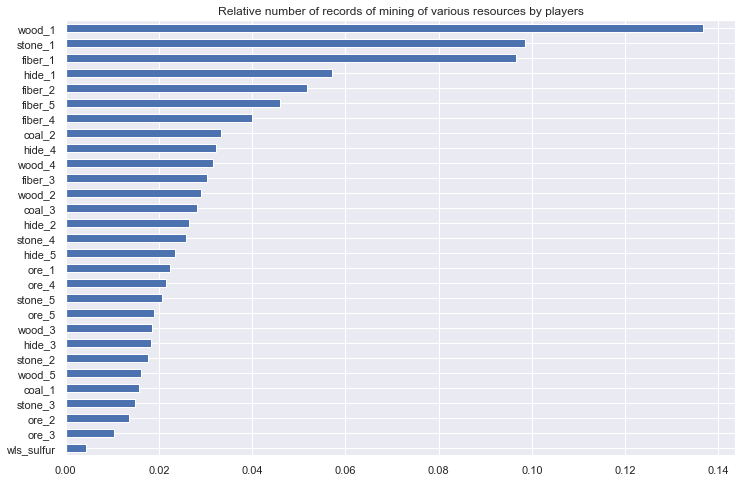

In [29]:
data['resource'].value_counts(normalize=True).sort_values().plot.barh()
plt.title('Relative number of records of mining of various resources by players')
plt.rcParams["figure.figsize"] = (12,10)

plt.show()

According to the number of logs on mining particular resource, the first tier resources are the most frequently seen.

It is worth studying the rarest resources more carefully.\
For example, sulfur, which does not have different tiers. Is it because it is a valuable resource throughout the game? Or is there another explanation?

### Studying the rate of obtaining resources

In [30]:
data.describe()['gain_count']

count   15,422,689.00
mean             3.55
std              5.84
min              1.00
25%              1.00
50%              2.00
75%              3.00
max            300.00
Name: gain_count, dtype: float64

During the initial analysis, I noticed that the resources drop to players unevenly. Some resources drop in large quantities, and some in smaller quantities.\
So, from the record above, it can be seen that the maximum number of the resource that has dropped at a time is 300, while usually this number fluctuates around 1-3 pieces at a time.

**Plan**: I will study what is the average drop rate of each resource.

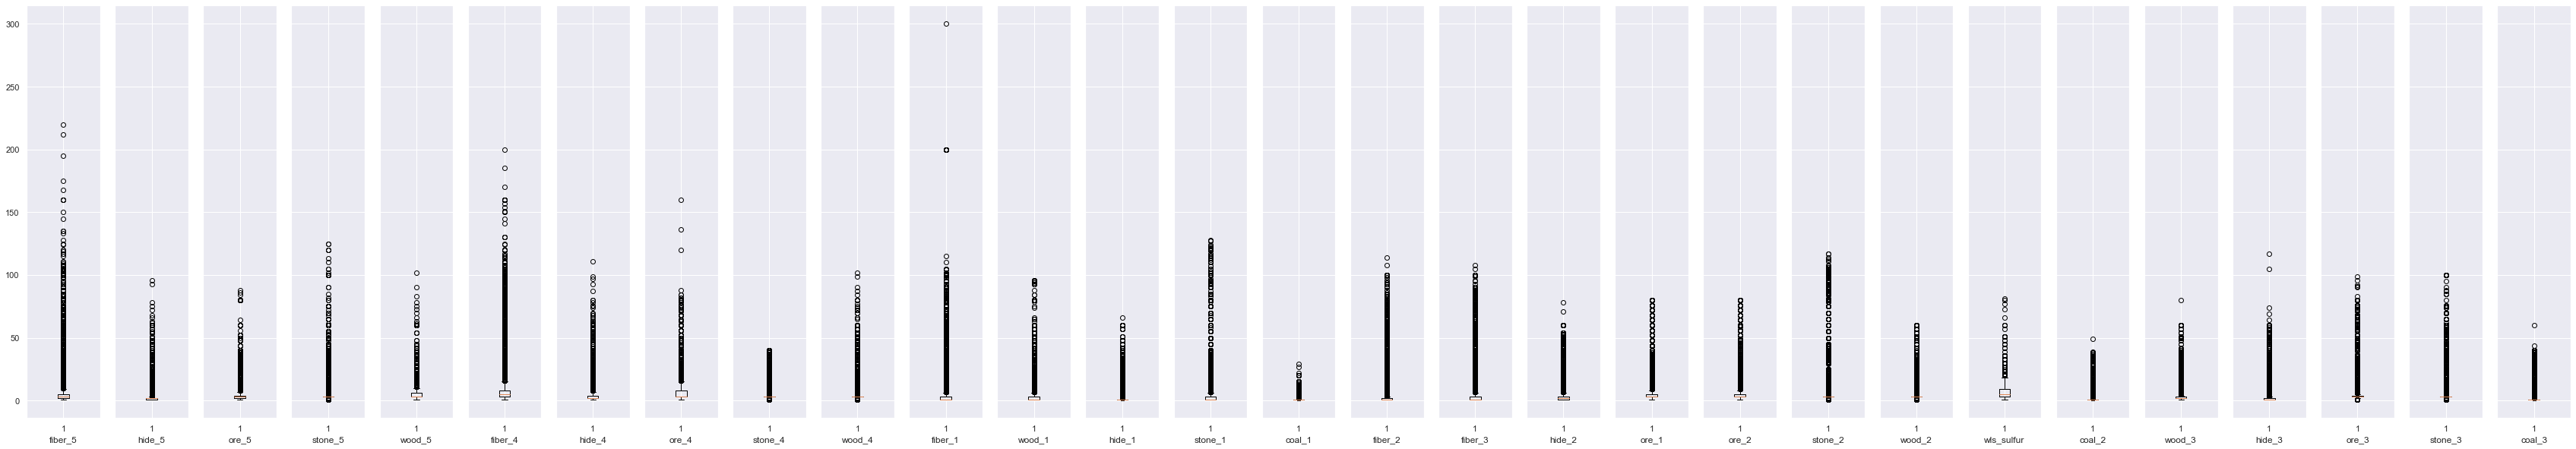

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=len(data['resource'].unique()), sharey=True ,figsize=(60, 10))
i=0
for res in data['resource'].unique():
    axs[i].boxplot(x=data.loc[data['resource']==res]['gain_count'])
    axs[i].set_xlabel(res)
    i+=1

plt.show()

Boxplots show that resources usually drop in small amounts up to 5-10 pieces.\ 
However in rare cases more than 100 or 200 units can be obtained at a time.

I assume that this is due to the presence of some kind of chests and quest rewards in the game.\
This explains why players can get a large amount of resources at a time.\
However, most of the resources are mined by grinding (chopping trees, for example) and receiving a small amount at a time.

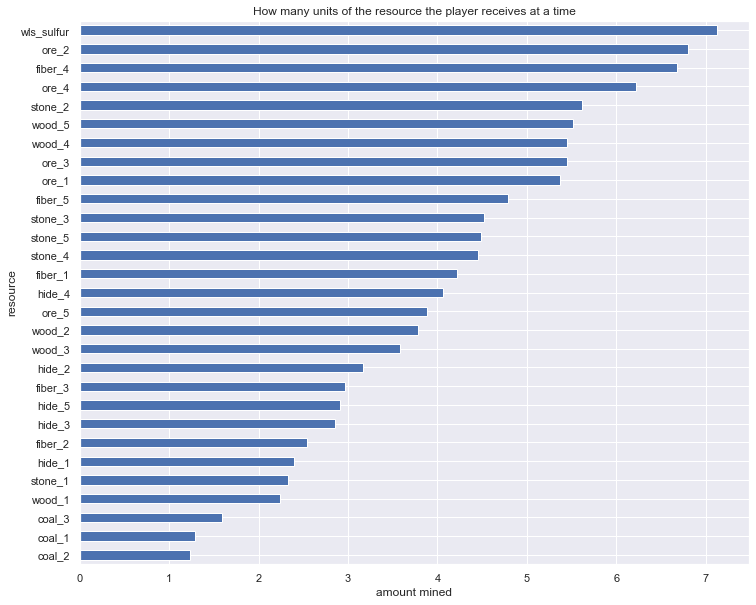

In [32]:
data.groupby('resource')['gain_count'].mean().sort_values().plot.barh()
plt.title('How many units of the resource the player receives at a time')
plt.xlabel('amount mined')

plt.show()

- Curiously, the only resource without a resource_tier — sulfur, has the largest drop rate.\
- Coal drop out rate is the lowest. You can also note that it has only three resource tiers.

It is possible that coal and sulfur are important throughout the game and may go beyond its tier?\
For example, Tier 3 coal may not lose its relevance for Tier 5 players. This needs to be further verified.

### Examining the time range during which each resource is relevant.

**Plan**:
- Select only those players who have records of collecting one type of resource of two tiers (tree_1 and tree_2 for example)
- Allocate from each of these players only these resources.\
    Allocate the minimum and maximum time that players take to stop mining resource of lower tier and start mining a resource of a higher tier.\
    Basically, I want to find a timestamp when the player stopped mining Tree_1 (example) and started mining Tree_2.
- Eliminate extreme outliers if needed
- Highlight mean and median values
- Build charts, draw conclusions

Let's get a list of players who have records of obtaining one resource of two tiers.

Focusing on these players, it will be possible to find time intervals when players first receive the resource of a higher tier.

In [33]:
data_unique_resources = data.groupby('user_id')['resource'].unique() # get all unique resources that the player received

In [34]:
data_unique_resources

user_id
0000197394df45db9fe1d5db475a2809    [fiber_5, hide_5, ore_5, stone_5, wood_5]
00023fbc0513473881e457b3439dc224                           [fiber_5, stone_5]
00057b61590147c6bc3c9fcf5e0d0e41                                    [fiber_5]
00062806ac3f45b8979ec560baec031a                                    [fiber_5]
000af54d4eae4e44b54352d9581e2f43    [fiber_5, hide_5, ore_5, stone_5, wood_5]
                                                      ...                    
fffadecf96a845809dff3d2dfc912161    [fiber_4, hide_4, ore_4, stone_4, wood_4]
fffb7b6079824c32af09bfc1015778e9                                    [fiber_1]
fffc99545db54fb38622685b2127c501                                     [wood_1]
fffe2083482a44eebd7a0e1d0f10ff62                                    [fiber_1]
fffe3e8b06084f93b6284b87f98b456b           [fiber_1, hide_1, stone_1, wood_1]
Name: resource, Length: 41543, dtype: object

In [35]:
def remove_number(row):
    # removes a number of the resource, for example turning "wood_5" into "wood" 
    new_row = []
    for i in row:
        for x in ['_1', '_2', '_3', '_4', '_5']:
            if x in i:
                z = i.replace(x, '')
                new_row.append(z)
    return new_row

In [36]:
data_unique_resources = data_unique_resources.apply(remove_number)

In [37]:
def check_duplicates(row): 
    # returns True if there are duplicates in the row, otherwise returns False
    if len(set(row)) == len(row):
        return False
    else:
        result = [item for item, count in collections.Counter(row).items() if count > 1]
        return result

In [38]:
data_unique_resources = data_unique_resources.apply(check_duplicates)

In [39]:
data_unique_resources = data_unique_resources[data_unique_resources!=False]

In [40]:
data_unique_resources

user_id
a00103076682429fbcbd62f6e68cae93                            [fiber, wood]
a0058127cbbf4792b03a9d8e3d9466da                                  [fiber]
a005883e10194686b9e45661aa731f4a          [fiber, hide, ore, stone, wood]
a0062969e61c47fe83c75b05075bab49    [coal, fiber, hide, ore, stone, wood]
a01073cb35dd4fbb81e5b24eb40cc781                     [fiber, stone, wood]
                                                    ...                  
fff2209af06e4a4f9a382818311a2e84          [fiber, hide, ore, stone, wood]
fff24b2e19874a1ead49566d2b4b04c0                                  [fiber]
fff3496566fc4d42b748b343995713dd    [coal, fiber, hide, ore, stone, wood]
fff7510538d1485babdef91a5bcf116f          [fiber, hide, ore, stone, wood]
fff8037af465427eb1aa858724adde00          [fiber, hide, ore, stone, wood]
Name: resource, Length: 11255, dtype: object

In [41]:
data_multiple_resources = data.loc[data['user_id'].isin(data_unique_resources.index)]

In [42]:
data_multiple_resources = data_multiple_resources.pivot_table(index = 'user_id', 
                                                              columns = 'resource', 
                                                              values='playtime', 
                                                              aggfunc='first').drop('wls_sulfur', axis=1)

Now I only need to leave records about mining of those resources that are found twice on different tiers for each of the players.

In [43]:
def leave_only_second(row):
    # leaves only second appearence of the duplicating values in each row
    for i in range(27,0,-1):
        if (np.isfinite(row[i])) and (np.isfinite(row[i-1]) == False):
            row[i] = np.nan
    return row

In [44]:
data_multiple_cut = data_multiple_resources.apply(leave_only_second, axis=1)

In [45]:
data_multiple_resources.drop(['coal_1', 'fiber_1', 'hide_1', 'ore_1', 'stone_1', 'wood_1'], axis=1, inplace=True)
data_multiple_cut.drop(['coal_1', 'fiber_1', 'hide_1', 'ore_1', 'stone_1', 'wood_1'], axis=1, inplace=True)

In [46]:
data_multiple_cut.head()

resource,coal_2,coal_3,fiber_2,fiber_3,fiber_4,fiber_5,hide_2,hide_3,hide_4,hide_5,ore_2,ore_3,ore_4,ore_5,stone_2,stone_3,stone_4,stone_5,wood_2,wood_3,wood_4,wood_5
user_id,,,,,,,,,,,,,,,,,,,,,,
a00103076682429fbcbd62f6e68cae93,NaN,NaN,NaN,NaN,NaN,"360,879.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"367,171.00"
a0058127cbbf4792b03a9d8e3d9466da,NaN,NaN,NaN,NaN,NaN,"320,815.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a005883e10194686b9e45661aa731f4a,NaN,NaN,"4,564.00","23,137.00",NaN,NaN,"5,392.00",NaN,NaN,NaN,"15,184.00",NaN,NaN,NaN,"17,638.00",NaN,NaN,NaN,"11,232.00",NaN,NaN,NaN
a0062969e61c47fe83c75b05075bab49,"116,458.00",NaN,"2,809.00","80,295.00","167,713.00",NaN,"3,190.00",NaN,NaN,NaN,"17,906.00",NaN,NaN,NaN,"35,026.00",NaN,NaN,NaN,"9,908.00","145,646.00",NaN,NaN
a01073cb35dd4fbb81e5b24eb40cc781,NaN,NaN,235.00,"47,967.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"46,928.00",NaN,NaN,NaN,"6,502.00",NaN,NaN,NaN


Now I can extract the average time when players get access to certain resources from the data

In [47]:
first_resource_time_stats = pd.DataFrame(columns=['mean', 'median'])

first_resource_time_stats['mean'] = data_multiple_cut.mean().round()
first_resource_time_stats['median'] = data_multiple_cut.median()

In [48]:
first_resource_time_stats.sort_values(by='median', inplace=True)

In [49]:
first_resource_time_stats

,mean,median
resource,,
hide_2,"5,831.00","3,004.00"
fiber_2,"4,468.00","3,323.00"
wood_2,"15,157.00","11,649.50"
stone_2,"20,521.00","16,057.00"
ore_2,"25,506.00","18,309.00"
fiber_3,"31,699.00","25,344.00"
hide_3,"55,165.00","44,531.00"
coal_2,"56,560.00","45,656.00"
ore_3,"57,005.00","45,771.00"


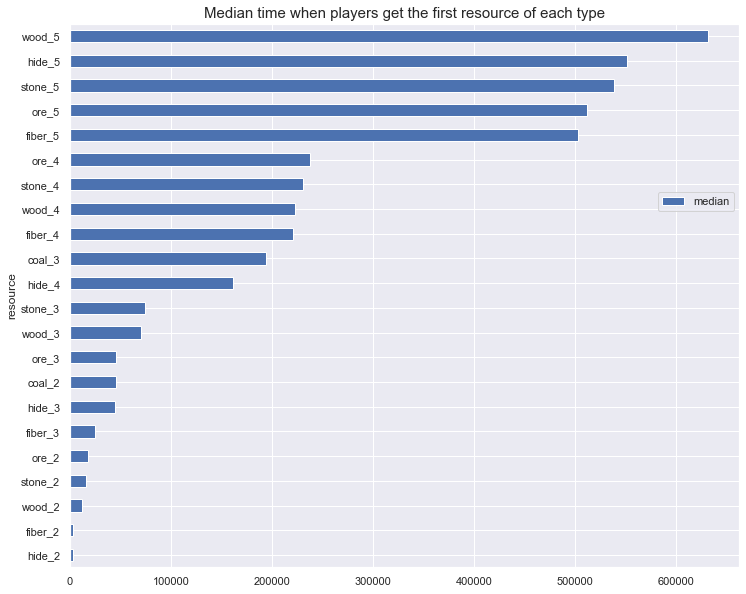

In [50]:
ax = first_resource_time_stats.drop('mean',axis=1).plot.barh()
plt.legend(bbox_to_anchor=(1, 0.7), bbox_transform=ax.transAxes)
plt.title('Median time when players get the first resource of each type', fontsize=15)
plt.show()

Since the mean value tends to give higher results, for the analysis I will focus on the median values.

From this graph, we can conclude that:

- Players consistently mine resources of subsequent tiers
- Tier 2 Coal should be treated as a Tier 3 resource, Tier 3 Coal as a Tier 4 resource.
- In general, resources within the same resource_tier consistently and in a short period of time become available to the players.\
    On the graph, you can clearly distinguish resource segments by tiers.

## Dive deeper into the total amount of resources obtained by the players.

Let's learn more about total number of resources mined by the players.

In [51]:
resource_table = data.pivot_table(index=['user_id', 'resource'], values='gain_count', aggfunc='sum')

In [52]:
resource_table.groupby('resource').max()

,gain_count
resource,
coal_1,349
coal_2,698
coal_3,698
fiber_1,698
fiber_2,698
fiber_3,698
fiber_4,697
fiber_5,695
hide_1,597


**UPD**: According to the data source, the dataset contains records of only 698 maximum total collected resources of each type by each player.\
I can immediately spot that ore_1, hide_1 and coal_1 don't even reach the 698 mark.\
I can conclude that these resources are quickly replaced with similar ones of a higher tier.

Sulfur also stands out - I'm almost sure that this is a quest item that players need to collect to progress in the game.\
Once ~350 units are mined, the resource is never used again.

### How many units of each resource players need before they switch to a similar resource of a higher tier?

**Plan**:
- The hypothesis is that once players start to mine a resource of certain tier, they abandon mining similar resource of a lower tier.
- To test it I will select players with a large amount of collected resources of different tiers.
- Next I will calculate the mean amount of resources they have collected.
- As a result, it will be possible to see how many resources were collected by the players during their lifetime\
    Using this data I will be able to conclude how many resources a player needs to advance to the next tier.

In [53]:
res_analysis = data.pivot_table(index = 'user_id', columns = 'resource', values='gain_count', aggfunc='sum')

In [54]:
res_analysis_max_tier_4 = res_analysis.dropna(thresh=23)
res_analysis_max_tier_5 = res_analysis.dropna()

In [55]:
print('The total number of players with available data on the extraction of resources of tier 4 and above:', res_analysis_max_tier_4.shape[0])
print('The total number of players with available data on the extraction of resources of all 5 tiers:', res_analysis_max_tier_5.shape[0])

The total number of players with available data on the extraction of resources of tier 4 and above: 548
The total number of players with available data on the extraction of resources of all 5 tiers: 102


I really want to use the data of those 102 players for the analysis.\
But first I will make sure that their behaviour is similar to those 548 players who made it to tier 4.

In [56]:
r_table = pd.concat([res_analysis_max_tier_5.mean(), res_analysis_max_tier_4.mean()], axis=1)
r_table.columns = ['All 5 tiers', '4 tiers']

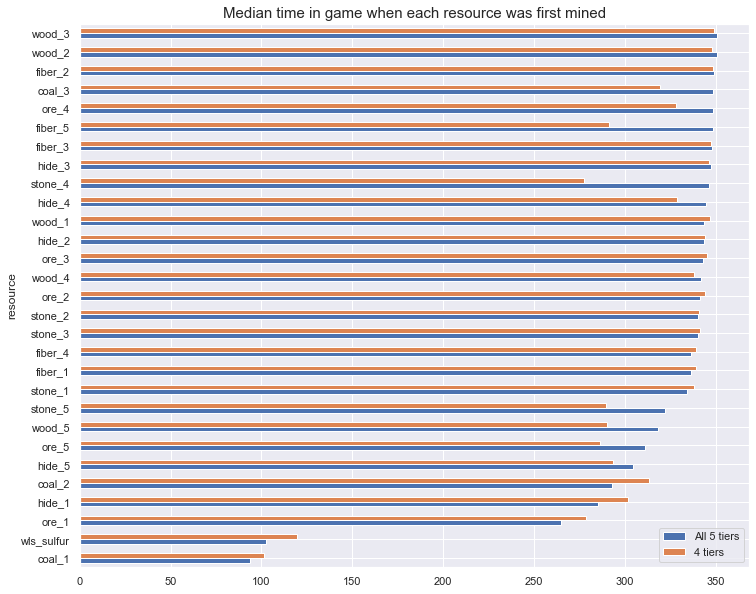

In [57]:
ax = r_table.sort_values(by='All 5 tiers').plot.barh()
plt.title('Median time in game when each resource was first mined', fontsize=15)
plt.show()

You may notice that, in addition to Tier 5 and Tier 4 resources, the resource collection data looks similar.\
What's more important, most resources require roughly 300 units to be mined before players start gathering resources for the next tier.

Thus, it is possible to measure the mining rate of the first 300-350 units of each resource.\
Using this data, I can calculate the speed at which players collect the amount of resources needed for the progression\
and from here calculate the comparative value of each resource.

The exceptions are coal_1, sulfur and ore_1.\
The first two require only about 100 units before they lose their relevance.\
ore_1 is more similar to the rest of the resources, but loses its relevance a little earlier - at around 260-270 units mark.

## Let's determine the time when the players get the last unit of each resource

In [58]:
data_multiple_resources_2 = data.loc[data['user_id'].isin(data_unique_resources.index)]

In [59]:
data_multiple_resources_2 = data_multiple_resources_2.pivot_table(index = 'user_id',
                                                                  columns = 'resource', 
                                                                  values='playtime', 
                                                                  aggfunc='last').drop('wls_sulfur', axis=1)

In [60]:
def leave_only_first(row):
    # leaves only first appearence of the duplicating values in each row
    
    for i in range(len(row)-1):
        if (np.isfinite(row[i+1]) == False):
            row[i] = np.nan
    return row

In [61]:
data_multiple_cut_2 = data_multiple_resources_2.apply(leave_only_first, axis=1)
data_multiple_cut_2.head()

resource,coal_1,coal_2,coal_3,fiber_1,fiber_2,fiber_3,fiber_4,fiber_5,hide_1,hide_2,hide_3,hide_4,hide_5,ore_1,ore_2,ore_3,ore_4,ore_5,stone_1,stone_2,stone_3,stone_4,stone_5,wood_1,wood_2,wood_3,wood_4,wood_5
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a00103076682429fbcbd62f6e68cae93,NaN,NaN,NaN,NaN,NaN,NaN,"367,270.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"394,008.00","407,203.00"
a0058127cbbf4792b03a9d8e3d9466da,NaN,NaN,NaN,NaN,NaN,NaN,"322,158.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a005883e10194686b9e45661aa731f4a,NaN,NaN,NaN,"9,528.00","69,247.00",NaN,NaN,NaN,"52,396.00",NaN,NaN,NaN,NaN,"79,597.00",NaN,NaN,NaN,NaN,"24,047.00",NaN,NaN,NaN,NaN,"16,876.00",NaN,NaN,NaN,NaN
a0062969e61c47fe83c75b05075bab49,"78,226.00",NaN,NaN,"22,753.00","122,889.00","221,115.00",NaN,NaN,"79,069.00",NaN,NaN,NaN,NaN,"59,247.00",NaN,NaN,NaN,NaN,"77,716.00",NaN,NaN,NaN,NaN,"35,953.00","110,639.00",NaN,NaN,NaN
a01073cb35dd4fbb81e5b24eb40cc781,NaN,NaN,NaN,"19,511.00","186,369.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"91,637.00",NaN,NaN,NaN,NaN,"47,047.00",NaN,NaN,NaN,NaN


In [62]:
last_resource_time_stats = pd.DataFrame(columns=['mean', 'median'])

last_resource_time_stats['mean'] = data_multiple_cut_2.mean().round()
last_resource_time_stats['median'] = data_multiple_cut_2.median()

In [63]:
last_resource_time_stats.sort_values(by='median', inplace=True)
last_resource_time_stats

,mean,median
resource,,
fiber_1,"21,141.00","18,467.00"
wood_1,"27,857.00","24,388.00"
stone_1,"42,456.00","37,047.00"
hide_1,"70,421.00","64,735.00"
ore_1,"72,186.00","65,858.00"
coal_1,"83,279.00","76,343.00"
fiber_2,"94,823.00","85,368.00"
wood_2,"116,067.00","102,851.00"
stone_2,"133,253.00","119,850.00"


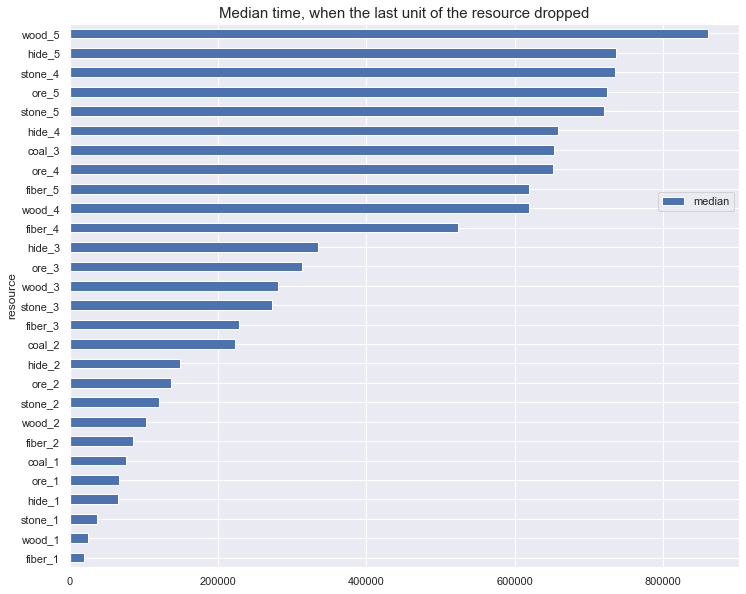

In [64]:
ax = last_resource_time_stats.drop('mean',axis=1).plot.barh()
plt.legend(bbox_to_anchor=(1, 0.7), bbox_transform=ax.transAxes)
plt.title('Median time, when the last unit of the resource dropped', fontsize=15)
plt.show()

### Time periods when players get each recource

In [65]:
first_last_res_table = pd.concat([first_resource_time_stats, 
                                  last_resource_time_stats], axis=1, join="inner")

In [66]:
first_last_res_table.drop('mean', axis=1, inplace=True)
first_last_res_table.columns = ['first_resource', 'last_resource']
first_last_res_table

,first_resource,last_resource
resource,,
hide_2,"3,004.00","148,359.00"
fiber_2,"3,323.00","85,368.00"
wood_2,"11,649.50","102,851.00"
stone_2,"16,057.00","119,850.00"
ore_2,"18,309.00","136,711.00"
fiber_3,"25,344.00","228,045.00"
hide_3,"44,531.00","334,448.00"
coal_2,"45,656.00","222,229.50"
ore_3,"45,771.00","313,278.00"


In [67]:
first_last_res_table = first_last_res_table.reindex(['hide_1', 'hide_2', 'hide_3', 'hide_4', 'hide_5',\
                                                     'fiber_1', 'fiber_2', 'fiber_3','fiber_4', 'fiber_5',\
                                                     'wood_1', 'wood_2', 'wood_3', 'wood_4', 'wood_5',\
                                                     'ore_1', 'ore_2','ore_3', 'ore_4', 'ore_5',\
                                                     'stone_1', 'stone_2', 'stone_3', 'stone_4', 'stone_5',\
                                                     'coal_1', 'coal_2', 'coal_3'])

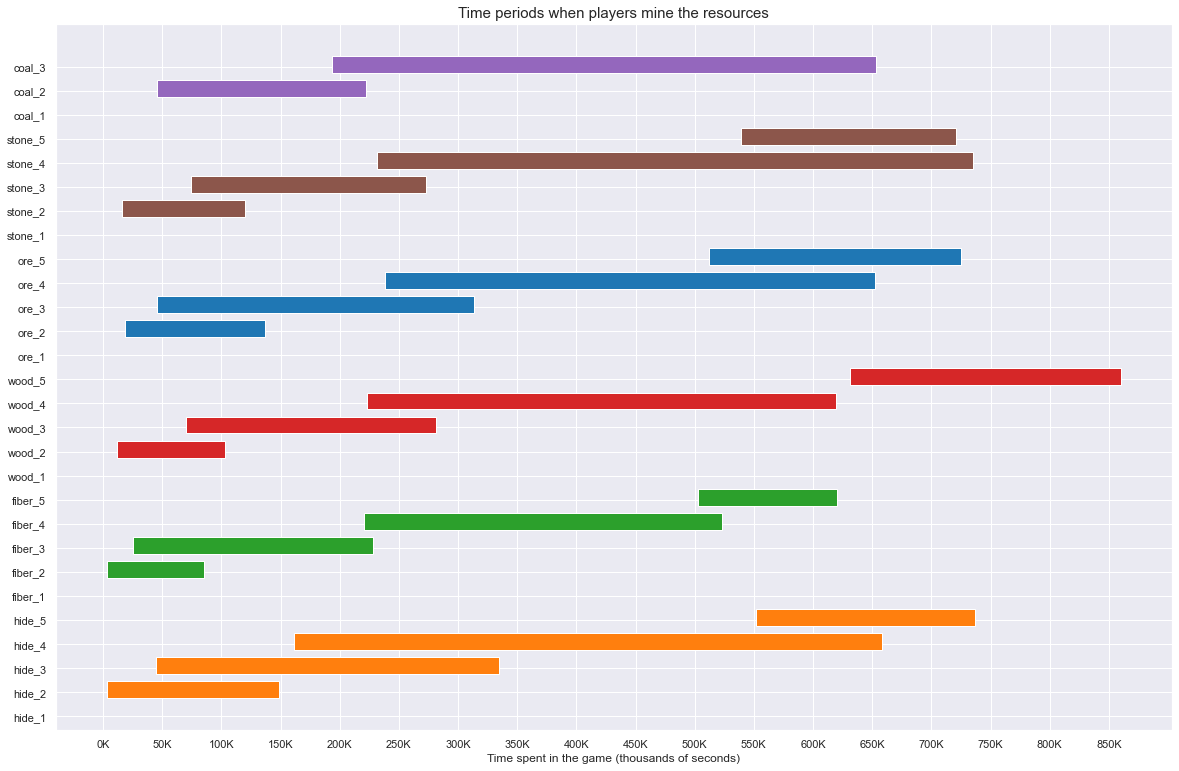

In [68]:
colors = ['tab:orange', 'tab:green', 'tab:red', 'tab:blue', 'tab:brown', 'tab:purple', 'tab:olive']
c_counter = 0
fig, ax = plt.subplots(figsize=(20, 13))
for i in range(first_last_res_table.shape[0]):
    if (i % 5 == 0) and (i!=0):
        c_counter+=1
    first_res_timestamp = first_last_res_table.iloc[i][0]
    last_res_timestamp = first_last_res_table.iloc[i][1]
    difference = last_res_timestamp - first_res_timestamp
    ax.broken_barh([(first_res_timestamp, difference)], (10*i-2.5, 7), facecolors=[colors[c_counter]])
                    
ax.grid(True)
ax.set_yticks([i*10 for i in range(first_last_res_table.shape[0])])
ax.set_yticklabels(labels=first_last_res_table.index)
ax.set_title('Time periods when players mine the resources', fontsize=15)
ax.set_xlabel('Time spent in the game (thousands of seconds)')
ax.xaxis.set_ticks(np.arange(0, 900000, 50000))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

plt.show() 

As you can see from the graph above, players continue to mine resources of a lower tier for some time after gaining access to the resources of the next tier.

However, at the same time, they completely stop extracting resources of the tier before last (except for tier 1).\
For example, players who have access to the Tier 4 tree do not mine the Tier 2 tree at all.\
However, this may be due to a limitation in the maximum number of resources equal to 698 in this dataset.

You can also see from the graph that each subsequent resource requires more time before it becomes available than the previous one.\
You can immediately estimate that Tier 4 resources will take ten times more time to mine than Tier 1 resources.

To estimate the cost of resources, I want to find a certain point in time when the players' need for a particular resource decreases.

My hypothesis is that this is the point at which players gain access to this higher tier resource, but this needs to be verified.\
I'll try to measure the rate at which players collect resources at different points in time in order to find some turning point when the extraction of this resource becomes noticeably easier.

### Analyze the time it takes players to collect every n resources

**Plan**:
Calculate the average speed at which the players mined the first, second, etc. n resources to see the dynamics of resource extraction.
Since almost all resources have a threshold of 300 before a similar higher tier resource becomes available,\
I will take n as 100 to see how the dynamics change before and after collecting 300 resources and if these phenomena are related at all.

I will calculate this parameter for all pairs from zero to 600 resources

In [69]:
def threshold_res_playtime(df, resource, max_threshold, threshold_step): 
    """
    Return two series that contain mean time when users first hit bottom and top thresholds
    """
    
    #select only one resource
    resource_time_table = df.loc[df['resource']==resource]
    resource_time_table = resource_time_table[['user_id', 'playtime', 'gain_count']]
    
    #adds counter column that calculates total resource at a given playtime
    resource_time_table['counter'] = resource_time_table.groupby('user_id')['gain_count'].cumsum()
    
    #get first occurence of the counter hitting the threshold
    resource_time_table.drop('gain_count', axis=1, inplace=True)
    
    threshold_hit_table = []
    for i in range(1, (max_threshold // threshold_step)+1):
        bottom_threshold_hit_time = resource_time_table.loc[resource_time_table['counter'] >= (i-1)*threshold_step].groupby('user_id').first()
        upper_threshold_hit_time = resource_time_table.loc[resource_time_table['counter'] >= i*threshold_step].groupby('user_id').first()
        
        threshold_reach_time = upper_threshold_hit_time['playtime'].mean() - bottom_threshold_hit_time['playtime'].mean()
        threshold_hit_table.append(threshold_reach_time)
            
    return threshold_hit_table

In [70]:
res_threshold_table = pd.DataFrame(columns=['Time to get 0-100 units','Time to get 100-200 units', 'Time to get 200-300 units',
                                           'Time to get 300-400 units', 'Time to get 400-500 units','Time to get 500-600 units'])

res_threshold_table['resource'] = data['resource'].unique()
res_threshold_table.set_index(res_threshold_table['resource'], inplace=True)
res_threshold_table.drop('resource', axis=1, inplace=True)

In [71]:
for i in range(res_threshold_table.shape[0]):
    resource = res_threshold_table.index[i]
    threshold_hits = threshold_res_playtime(df=data, resource=resource, max_threshold=600, threshold_step=100)
    
    res_threshold_table.iloc[i] = threshold_hits
    
res_threshold_table

,Time to get 0-100 units,Time to get 100-200 units,Time to get 200-300 units,Time to get 300-400 units,Time to get 400-500 units,Time to get 500-600 units
resource,,,,,,
fiber_5,"118,106.85","52,125.80","37,049.22","189,905.22","130,461.81","18,552.21"
hide_5,"231,689.53","74,560.83","55,873.31","86,170.28","413,330.50","364,482.00"
ore_5,"250,097.19","76,641.72","57,811.52","96,352.41","35,293.00","131,757.33"
stone_5,"207,171.23","68,286.50","43,567.42","98,633.58","141,840.00",NaN
wood_5,"129,332.87","53,989.13","43,022.58","161,473.84","32,492.00","56,157.93"
fiber_4,"36,146.92","28,505.43","27,384.32","273,670.18","93,366.89","23,231.11"
hide_4,"117,358.59","64,270.36","62,454.81","187,354.18","59,294.07","246,225.47"
ore_4,"89,983.69","60,694.43","58,074.54","182,453.08","108,581.58","13,301.83"
stone_4,"133,756.97","88,578.21","61,225.73","63,160.52","70,586.46","-15,778.32"


In [72]:
res_threshold_table.sort_values(by='Time to get 0-100 units', inplace=True)

Some values in the table turned out to be negative.\
This is most likely due to the small amount of data on the drop of such n quantity of resources.\
This leads to the average values to be negative just due to randomness. I will remove these values from the table.

C:\Users\Admin\AppData\Local\Temp\ipykernel_2852\3001205448.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[num].set_xticklabels(['0-100','100-200','200-300','300-400','400-500','500-600'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_2852\3001205448.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[num].set_xticklabels(['0-100','100-200','200-300','300-400','400-500','500-600'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_2852\3001205448.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[num].set_xticklabels(['0-100','100-200','200-300','300-400','400-500','500-600'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_2852\3001205448.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[num].set_xticklabels(['0-100','100-200','200-300','300-400','400-500','500-600'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_2852\3001205448.py:6: UserWarning: Fixed

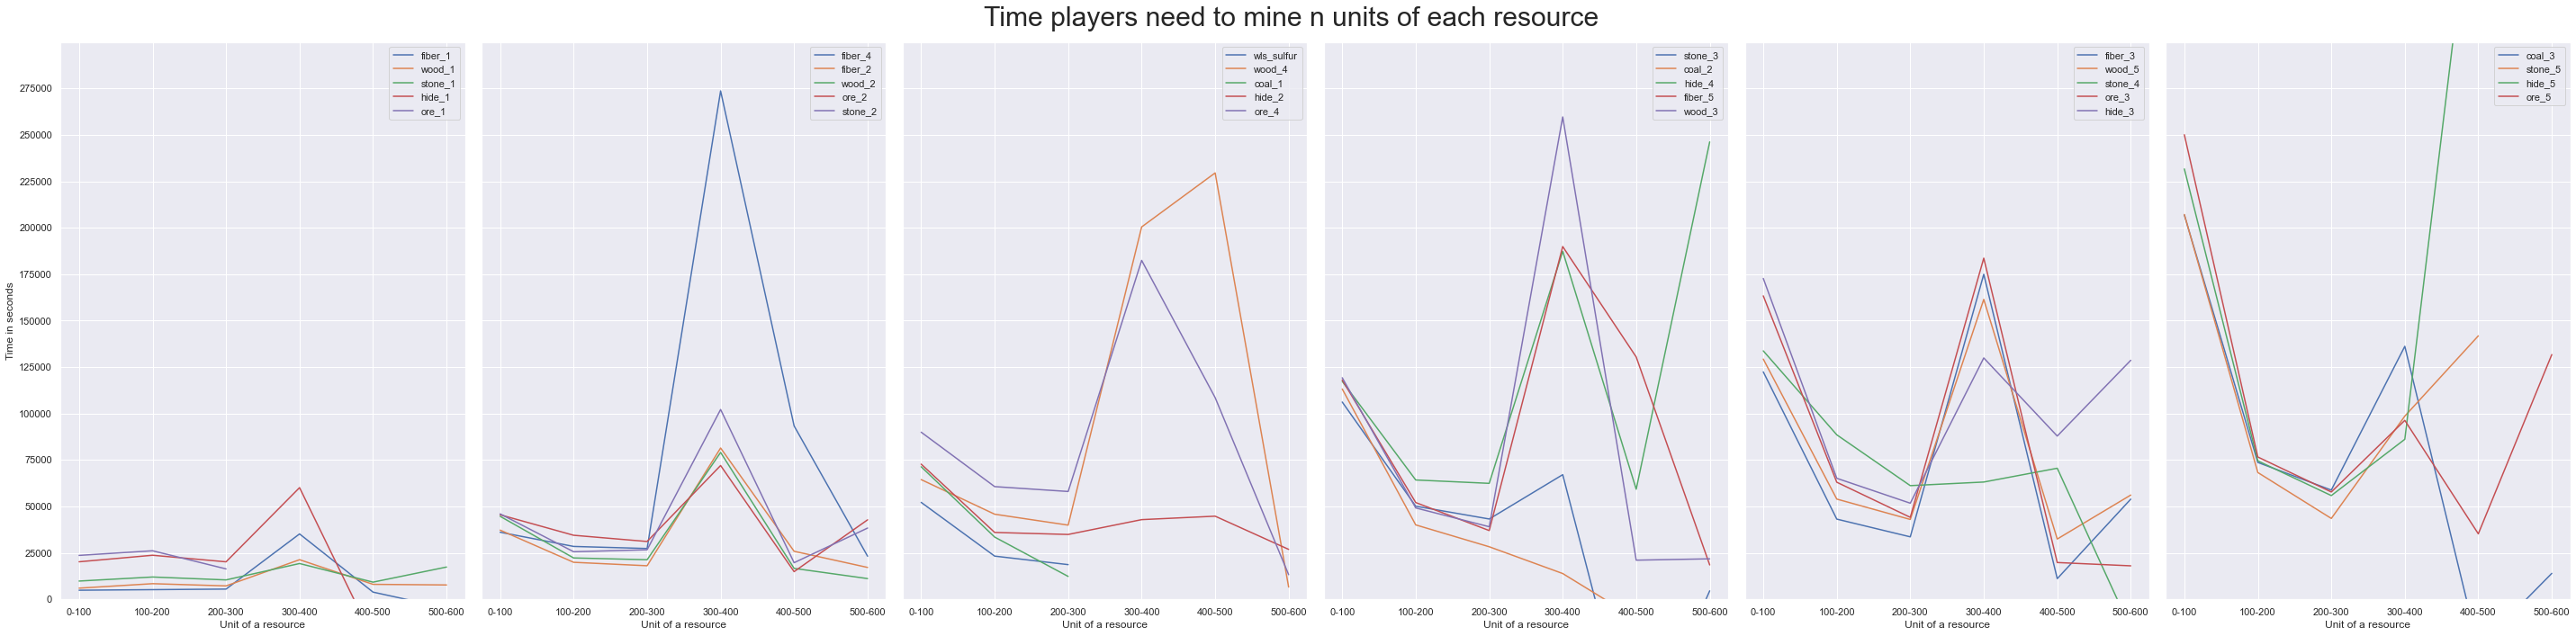

In [73]:
fig, axs = plt.subplots(1,6, figsize=(40,10), sharey=True)
fig.suptitle('Time players need to mine n units of each resource', fontsize=30)
for i in range(0, 29, 5):
    num = int(i/5)
    axs[num].plot(res_threshold_table.iloc[i:i+5].T, label=res_threshold_table.iloc[i:i+5].T.columns)
    axs[num].set_xticklabels(['0-100','100-200','200-300','300-400','400-500','500-600'])
    axs[num].legend()
    axs[num].legend()
    axs[num].yaxis.set_ticks(np.arange(0, 300000, 25000))
    axs[num].set_xlabel('Unit of a resource')

axs[0].set_ylabel('Time in seconds')
plt.tight_layout()

plt.ylim(0, 300000)
plt.show()

The charts above show that, as a rule, the first hundred resources are the hardest and longest to extract.\
Going forward, you have to spend less time on mining.

However, at the border of 300 resources, the extraction time of almost all resources goes up dramatically.\
Knowing that at the same timestamp, a similar resource of a higher tier becomes available to players,\
I can conclude that most likely players spend more time collecting resources after the third hundred simply because this resource becomes less relevant.\
Players switch their attention to a resource of a higher tier.

In this case, I can use the mark of 300 first collected resources to calculate the relative cost of resources.

## Resource "cost" estimation

**Plan**:
Knowing how many resources players need to move to the next tier (about 300 units for each type), I will calculate how long it takes players to collect this amount.

Actions:
- Get the median or average time of extraction of the first and ~300 units of each resource (for exceptions, take their own values).
- Subtract the minimum from the maximum value, thereby obtaining the time in seconds during which the players extract this resource.
- Take the most rapidly replaced resource as a base unit and calculate the "cost" of the remaining resources relative to it.

It is important to immediately note the corner cases that will need to be investigated separately:
- The resources sulfur and coal_1 only require ~100 units to be collected before players stop mining them.
- Tier 5 resources are not replaced by other resources, thus they are always required by players.\
    Therefore, to measure the speed of their collection, I can take the same value that is used for the rest of the resources, that is, the time to collect the first ~ 300 units.

In [74]:
def resource_counter(df, resource, threshold): 
    """
    Return a table with each unique users time mark when they hit the selected resource threshold
    """
    
    #select only one resource
    resource_time_table = df.loc[df['resource']==resource]
    resource_time_table = resource_time_table[['user_id', 'playtime', 'gain_count']]
    
    #adds counter column that calculates total resource at a given playtime
    resource_time_table['counter'] = resource_time_table.groupby('user_id')['gain_count'].cumsum()
    
    #get first occurence of the counter hitting the threshold
    resource_time_table.drop('gain_count', axis=1, inplace=True)
    resource_time_counter = resource_time_table.loc[resource_time_table['counter'] >= threshold].groupby('user_id').first()
    
    resource_time_counter.drop('counter', axis=1, inplace=True)
    resource_time_counter.rename(columns = {'playtime':resource}, inplace=True)
    
    return resource_time_counter.mean()

In [75]:
res_analysis_max_tier_5 = res_analysis_max_tier_5.mean()

For tier 5 resources, I set the level to 300 of the first mined resources, by analogy with the rest of the resources.

In [76]:
for i in ['coal_3', 'fiber_5', 'hide_5', 'ore_5', 'stone_5', 'wood_5']:
    res_analysis_max_tier_5[i] = 300
res_analysis_max_tier_5

resource
coal_1        93.70
coal_2       292.71
coal_3       300.00
fiber_1      336.24
fiber_2      348.84
fiber_3      348.07
fiber_4      336.36
fiber_5      300.00
hide_1       285.41
hide_2       343.36
hide_3       347.40
hide_4       344.69
hide_5       300.00
ore_1        264.58
ore_2        341.18
ore_3        343.10
ore_4        348.36
ore_5        300.00
stone_1      334.21
stone_2      340.29
stone_3      340.29
stone_4      346.39
stone_5      300.00
wls_sulfur   102.45
wood_1       343.66
wood_2       350.57
wood_3       350.86
wood_4       342.02
wood_5       300.00
dtype: float64

In [77]:
r_table = pd.DataFrame(columns=['resource', 'mean_threshold_time'])
r_table['resource'] = data['resource'].unique()

In [78]:
for i in range(res_analysis_max_tier_5.shape[0]):
    resource = res_analysis_max_tier_5.index[i]
    threshold = res_analysis_max_tier_5.iloc[i]
    resource_analysis = resource_counter(df=data, resource=resource, threshold=threshold)
    r_table.loc[r_table['resource']==str(resource), 'mean_threshold_time'] = round(resource_analysis[0])

In [79]:
r_table = r_table.sort_values(by='mean_threshold_time')
r_table

,resource,mean_threshold_time
10,fiber_1,18824
11,wood_1,24910
13,stone_1,36410
12,hide_1,62579
18,ore_1,63260
22,wls_sulfur,63435
14,coal_1,72631
15,fiber_2,93396
20,stone_2,131676
19,ore_2,150567


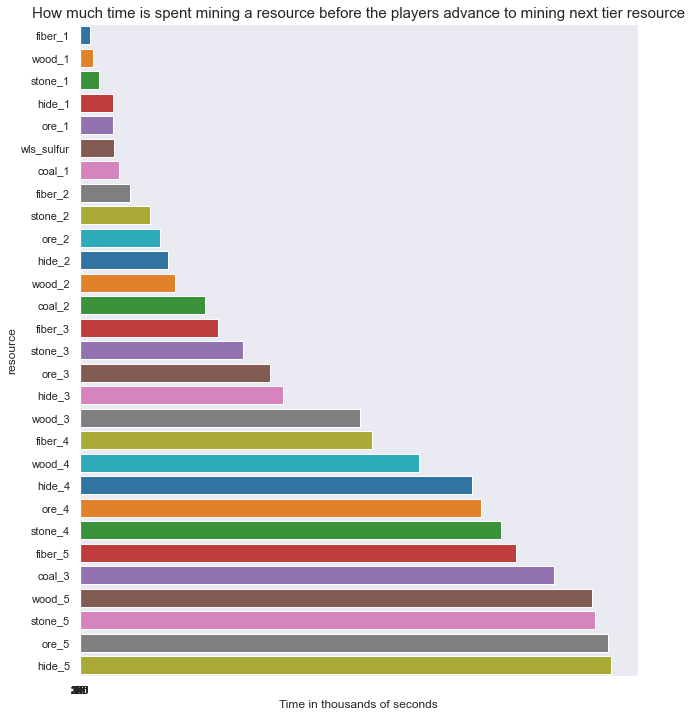

In [80]:
fig, ax = plt.subplots(figsize = (10,12))
plt.title("How much time is spent mining a resource before the players advance to mining next tier resource", fontsize=15)
ax = sns.barplot(data=r_table, palette='tab10', orient='h', y='resource', x='mean_threshold_time')
ax.ticklabel_format(axis = 'x', style ='Plain')
ax.set_xlabel("Time in thousands of seconds")
ax.xaxis.set_ticks(np.arange(0, 400, 25))
plt.show()

Ok, now I only need to calculate the relative cost of resources.\
As a measure unit, I will take the fastest mined resource — fiber_1.

In [81]:
r_table['fiber_1_relative_cost'] = r_table['mean_threshold_time']/r_table.iloc[0]['mean_threshold_time']

In [82]:
r_table

,resource,mean_threshold_time,fiber_1_relative_cost
10,fiber_1,18824,1.00
11,wood_1,24910,1.32
13,stone_1,36410,1.93
12,hide_1,62579,3.32
18,ore_1,63260,3.36
22,wls_sulfur,63435,3.37
14,coal_1,72631,3.86
15,fiber_2,93396,4.96
20,stone_2,131676,7.00
19,ore_2,150567,8.00


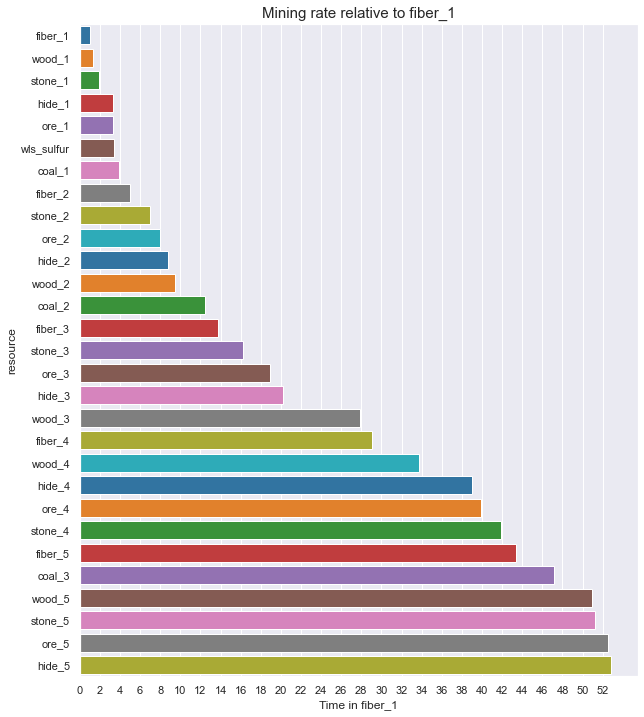

In [83]:
fig, ax = plt.subplots(figsize = (10,12))
plt.title("Mining rate relative to fiber_1", fontsize=15)
ax = sns.barplot(data=r_table, palette='tab10', orient='h', y='resource', x='fiber_1_relative_cost')
ax.ticklabel_format(axis = 'x', style ='Plain')
ax.set_xlabel("Time in fiber_1")
ax.xaxis.set_ticks(np.arange(0, 53, 2))
plt.show()

In [84]:
final_result = r_table.drop('mean_threshold_time', axis=1).set_index('resource')
final_result

,fiber_1_relative_cost
resource,
fiber_1,1.00
wood_1,1.32
stone_1,1.93
hide_1,3.32
ore_1,3.36
wls_sulfur,3.37
coal_1,3.86
fiber_2,4.96
stone_2,7.00


# Conclusion

In the course of work, I managed to calculate how many resources of one tier players need before they switch to a similar resource of a higher tier.\
This value is approximately equal to 300 +- 50 for all resources except coal_1, sulfur and ore_1, which lose their relevance for players earlier.

It was also impossible to select the upper border for the resources of the highest tier 5 by a similar method.\
Therefore, a limit of 300 first collected resources was used - approximately the same as for all other resources (except for exceptions mentioned earlier).

Next, I calculated the time required for players to collect the first n units of each resource, where n is the average limit after which players usually gain access to that higher-tier resource.\
The fastest to lose relevancy resource is fiber_1. Thus, it was used as a unit, relative to which the cost of all other resources was calculated.\
The results are summarized in a table and shown graphically below.

**Other findings**:
- Unlike other resources, players very quickly lose the need for the coal resource of the first tier.\
    After about the hundredth resource is collected, the resource is no longer needed for progression. Perhaps, there could be added some more usage for this resource.
- From the data I concluded that sulfur is most likely some kind of quest item that players need to progress in game. 
    If this is the case, then some similar resource could be added in the future as the player base is already familiar with this game mechanic.

In [85]:
final_result

,fiber_1_relative_cost
resource,
fiber_1,1.00
wood_1,1.32
stone_1,1.93
hide_1,3.32
ore_1,3.36
wls_sulfur,3.37
coal_1,3.86
fiber_2,4.96
stone_2,7.00


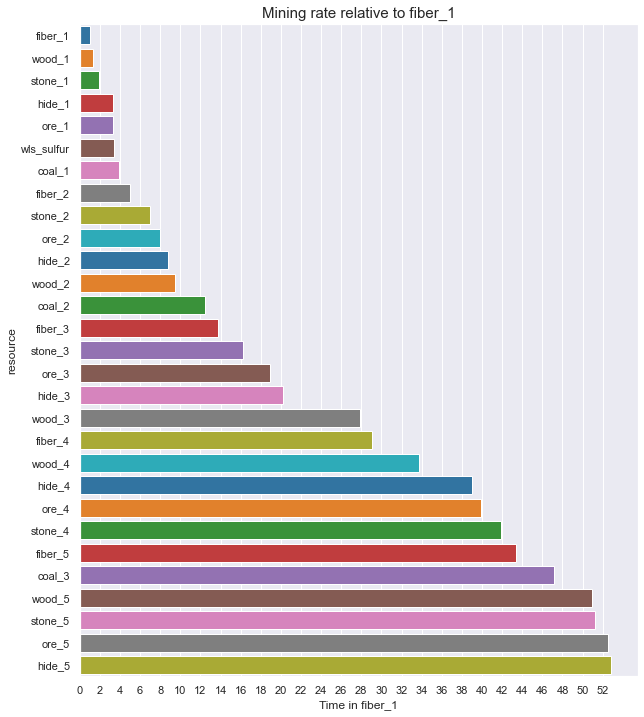

In [87]:
fig, ax = plt.subplots(figsize = (10,12))
plt.title("Mining rate relative to fiber_1", fontsize=15)
ax = sns.barplot(data=r_table, palette='tab10', orient='h', y='resource', x='fiber_1_relative_cost')
ax.ticklabel_format(axis = 'x', style ='Plain')
ax.set_xlabel("Time in fiber_1")
ax.xaxis.set_ticks(np.arange(0, 53, 2))
plt.show()